# Spatial averaged vector autoregressive (SAVAR) model 

SAVAR is a spatio-temporal model where some regions, the so-called modes, affect each other according to some underlying causal model. Modes are regions with covariant noise. We name components to the weighted average of the modes that affect the value of other modes in future time-steps. 

The model is given by the following expression: 

$$
	y_t^\ell:= \sum_{j=1}^{N}u^{\ell j}\sum_{i=1}^{N}\sum_{\tau=1}^{\tau_{max}}\phi^{ji}(\tau)\sum_{\ell}^{L}w^{i \ell} y_{t-\tau}^\ell+\epsilon^\ell_t
$$

where $y_t^\ell$ is the value of the random variable $y$ at time $t$ at location $\ell$, $u^{\ell j}$ is the coefficient that relates how the $j$-th component contributes to the value of $y^\ell_t$, $\phi^{ji}(\tau)$ is the contribution to the $i$-th component to the $j$-th component at time lag $\tau$, $w^{i\ell}$ is the coefficient that relates how $y^\ell$ contributes to the $i$-th and $\epsilon_t^\ell$ stands for a a noise term where $\epsilon_t^\ell \sim \mathcal{N}(\mu, \Sigma)$ and $\Sigma \in \mathbb{R}^{L\times L}$ is the correlation matrix.

the matrix form is given by

$$
	\mathbf{y}_t = W^+\sum_{\tau=1}^{\tau_{max}}\Phi(\tau) W \mathbf{y}_{t-\tau}+\mathbf{\epsilon}_t
$$

where $\mathbf y^T_t = (y^1_t, \dots, y^L_t)$, $u^{\ell j} \in W^+$, $\phi^{i j}(\tau)\in \Phi(\tau)$, $w^{i\ell} \in W$ and $\epsilon_t^\ell \in \mathbf \epsilon_t$. The matrix $W^+$ is the Moore-Penrose pseudoinvers of $W$. This is, $WW^+W=W$.


In [1]:
# Important, remember to install savar with `python setup.py isntall`
from savar.savar import SAVAR
import matplotlib.pyplot as plt
from savar.functions import create_random_mode, check_stability

import numpy as np

In [2]:
# Some definitions

nx = 30  
ny = 90 # Each component is 30x30
T = 500 # Time 

In [3]:
# Setup spatial weights of underlying processes

N = 3 # Three components

noise_weights = np.zeros((N, nx, ny))
modes_weights = np.zeros((N, nx, ny))

# This is an important parameter allows us to identify the modes because the covariance noise at grid level.
spatial_covariance = 10 

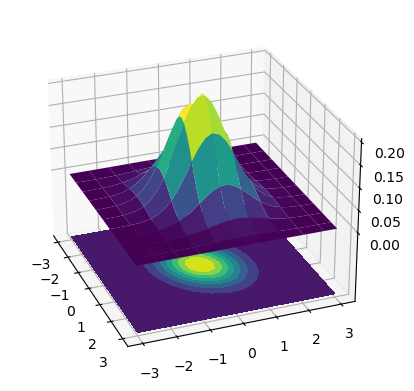

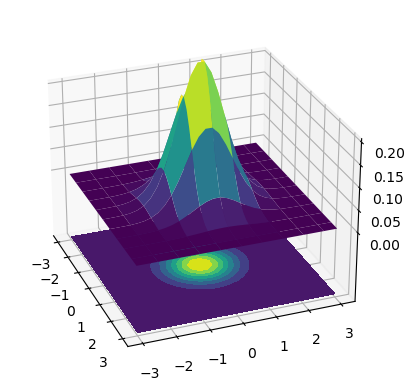

In [4]:
# There is a function to create random  modes 
_ = create_random_mode((30, 30), plot=True, random = True)

# If no random X is independent of y
_ = create_random_mode((30, 30), plot=True, random = False)

In [5]:
# We can create the modes with it.
noise_weights = np.zeros((N, nx, ny))
noise_weights[0, :, :30] = create_random_mode((30, 30), random = False)  # Random = False make modes round.
noise_weights[1, :, 30:60] = create_random_mode((30, 30), random = False)
noise_weights[2, :, 60:] = create_random_mode((30, 30), random = False)

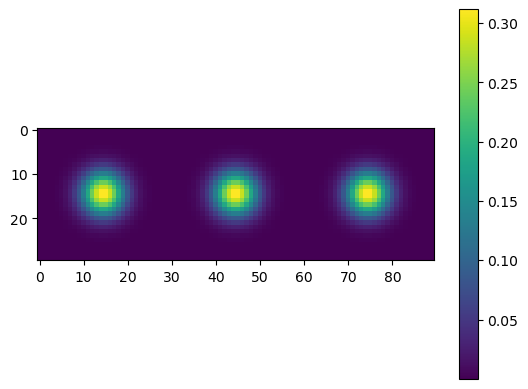

In [6]:
# How the modes look like
plt.imshow(noise_weights.sum(axis=0))
plt.colorbar()

With them, we define $\Sigma$. But is it also necessary to define $W$. This is, how we average this mode to influence other modes, according to an underlying VAR(p) process. This process is determined by $\Phi$ which we introduce in the same way as Tigramite.

In [7]:
# We can use the same
modes_weights = noise_weights

# And the causal model
links_coeffs = {
    0: [((0, -1), 0.5), ((2, -2), -0.2)],
    1: [((1, -1), 0.5), ((0, -1), 0.2)],
    2: [((2, -1), 0.5), ((1, -1), 0.2)]
}

# One good thing of SAVAR is that if the underlying process is stable and stationary, then SAVAR is also both. 
# Independently of W. This is, we only need to check for stationarity of \PHI and not of W^+\PHI W
check_stability(links_coeffs)

In [53]:
f_1, f_2, f_time_1, f_time_2 = 1, 2, 100, 150
time_len = 500
w_f = modes_weights
# A very simple method for adding a focring term (bias on the mean of the noise term)
forcing_dict = {
    "w_f": w_f,  # Shape of the mode of the forcing
    "f_1": f_1,  # Value of the forcing at period_1
    "f_2": f_2,  # Value of the forcing at period_2
    "f_time_1": f_time_1,  # The period one goes from t=0  to t=f_time_1
    "f_time_2": f_time_2,  # The period two goes from t= f_time_2 to the end. Between the two periods, the forcing is risen linearly
    "time_len": time_len,
}
# We could introduce seasonality if we would wish
season_dict = {"amplitude": 0.08,
               "period": 12}
# Add the parameters
savar_model = SAVAR(links_coeffs=links_coeffs,
                    time_length=time_len,
                    mode_weights=modes_weights,
                    season_dict=season_dict,
                    forcing_dict=forcing_dict
                    )
savar_model.generate_data()  # Remember to generate data, otherwise the data field will be empty

In [54]:
savar_model.data_field.shape  # Here is stored the data field

(2700, 500)

Get Varimax components
	 Get SVD
	 User-selected number of components: 60
	 Explaining 1.00 of variance
	 Varimax rotation
	 Further metrics


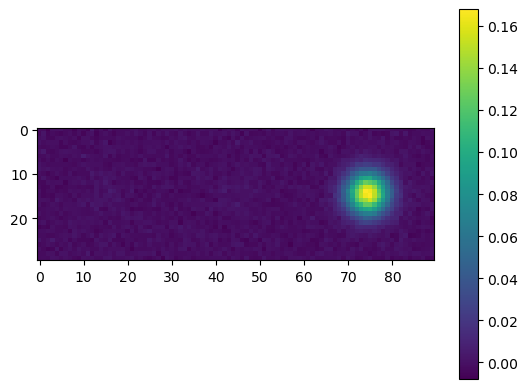

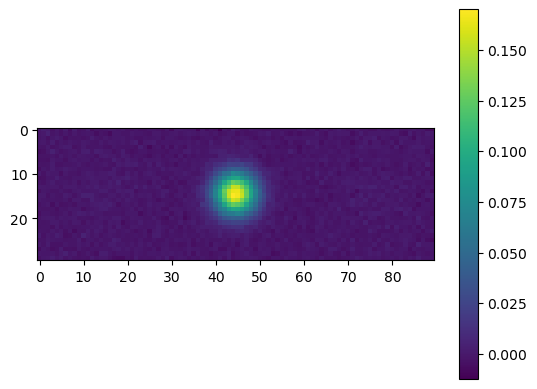

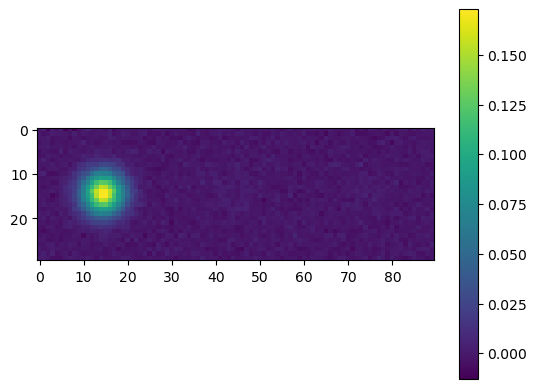

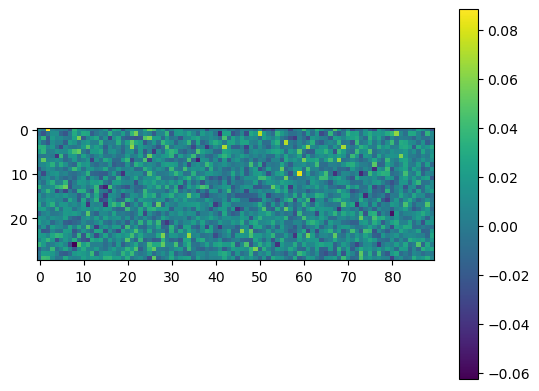

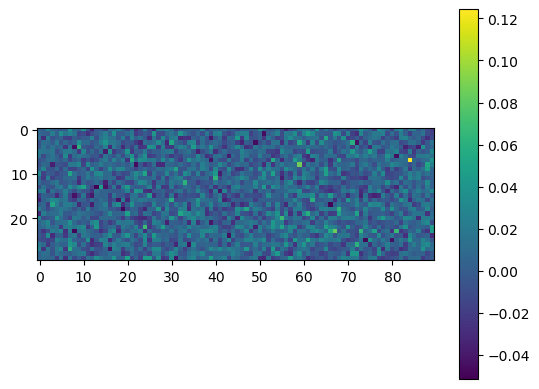

In [60]:
# You can use the varimax functions that come with SAVAR
# Or use the package varimax^+ [install it `pip install git+https://github.com/xtibau/varimax_plus.git#egg=varimax_plus`]
from copy import deepcopy
from savar.dim_methods import get_varimax_loadings_standard as varimax
modes = varimax(deepcopy(savar_model.data_field.transpose()))  # Use variamx to try to recover the weights
for i in range(5):
    plt.imshow(modes['weights'][:, i].reshape(30, 90))
    plt.colorbar()
    plt.show()

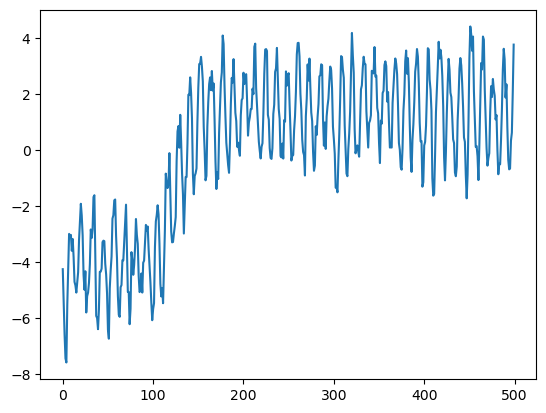

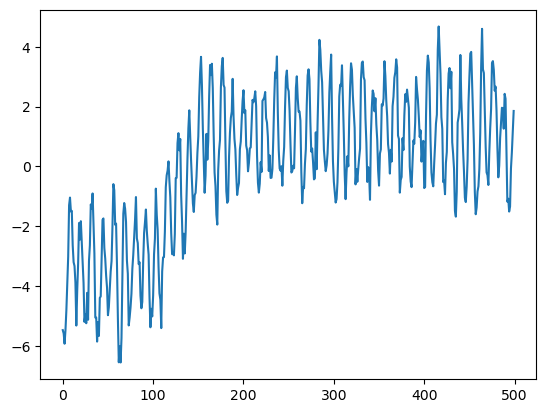

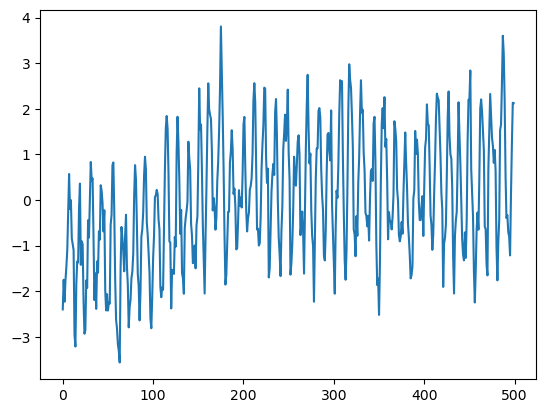

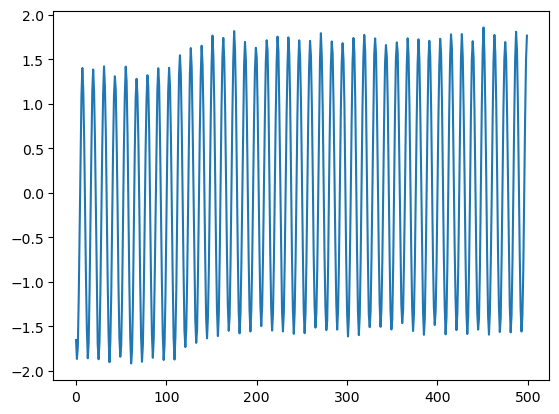

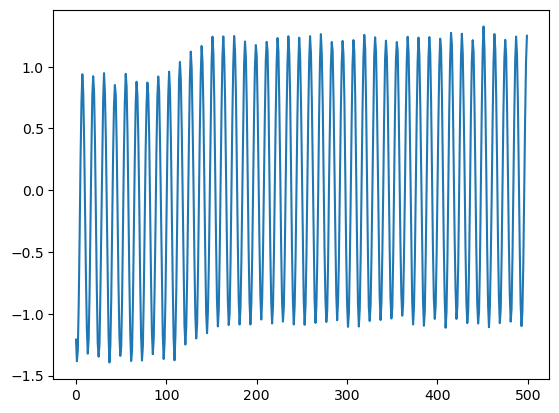

In [64]:
# We can print the modes directly
singal = savar_model.data_field.transpose() @ modes['weights']
for i in range(5):
    plt.plot(singal[:, i])
    plt.show()

In [65]:
# As expect data is strongly deasonalized, specially outside of the modes. 
# We also can see a change on the mean, due to the forcing.

### Model generator

There is a module for randomly generate models. It is useful for experimetns. It has some usefull functions. Let's see them.

In [95]:
from savar.model_generator import SavarGenerator

In [96]:
resolution = (30, 90)  # Total resolution
N = 3  # total number of modes
savar_generator = SavarGenerator(n_variables=100,
                      n_cross_links=10,
                      time_length=200)
# You need to generate the model
savar_model = savar_generator.generate_savar()
# You need to generate the data
savar_model.generate_data()

### Default parameters

#### Basic configuration.
- `links_coeffs`: dict = None Add a dictioniary if you know the coefficient 
- `n_variables`: int = 3, number of variables
- `time_length`: int = 500, number of time-stamps
- `transient`: int = 200, Is there a transient time?

#### Noise
- `noise_strength`: float = 1.,  $\mu_y$
- `noise_variance`: float = None,  $\Sigma_y$
- `noise_weights`: np.ndarray = None,  **depreciated**
- `resolution`: tuple = (10, 10),  $L$
- `noise_cov`: np.ndarray = None,,  **depreciated**
- `latent_noise_cov`: np.ndarray = None,  $D_x$
- `fast_cov`: np.ndarray = None,  $D_y$

#### Fields
The filds are just added before computing the VAR process. 
The recomendation is to use only `noise_data_field`.
- `data_field`: np.ndarray = None,
- `noise_data_field`: np.ndarray = None,
- `seasonal_data_field`: np.ndarray = None,
- `forcing_data_field`: np.ndarray = None,

#### Weights
- `mode_weights`: np.ndarray = None,  weights of the modes. If not `None` all next are ignored.
- `gaussian_shape`: bool = True, Do they have Gaussian shape?
- `random_mode`=True, ` round cercle or random shape?
- `dipole`: int = None, Are dipoles allowed?
- `mask_variables`: int = None, **depreciated**
- `norm_weight`: bool = True,  **depreciated**

#### Links
In case you want randomly generated causal graphs.
If you provide the `links_coeff`this is ignored.
- `n_cross_links`=3,
- `auto_coeffs_mean`: float = 0.3,  Mean of the autocorrelation links
- `auto_coffs_std`: float = 0.2,  Std of the autocorrelation links
- `auto_links`: bool = True, Are there autocorrelation links?
- `auto_strength_threshold`: float = 0.2, (abs($\phi^{ij}$) >= `auto_strength_threshold`)
- `auto_random_sign`: float = 0., chances of changing the sign of the auto correlation links.
- `cross_mean`: float = 0.3, mean of cross links
- `cross_std`: float = 0.2,  std of cross links
- `cross_threshold`: float = 0.2, same as with auto correlation links
- `cross_random_sign`: float = 0.2, same as with auto correlation links
- `tau_max`: int = 3, tau_min: int = 1, max tau of the links
- `n_trial`: int = 1000, model_seed: int = None, number of trails before raising error i stationarity has not been achieved

#### external forcings
Simple ways to add forcings
- `forcing_dict`: dict = None, as shown before
- `season_dict`: dict = None, as shown before

#### Ornstein-Uhlenbeck
To add an independent Ornstein-Uhlenbeck processes to some variable. If you wish to control to which variables, use the fileds.
- `ornstein_sigma`: float = None,
- `n_var_ornstein`: int = None, Number of variables affected by the processes

#### Lineartiy
**Depreciated**. Only linear is supported
- `linearity`: str = "linear" 
 
#### Verbose
- `verbose` bool = False
